Matplotlib is building the font cache; this may take a moment.


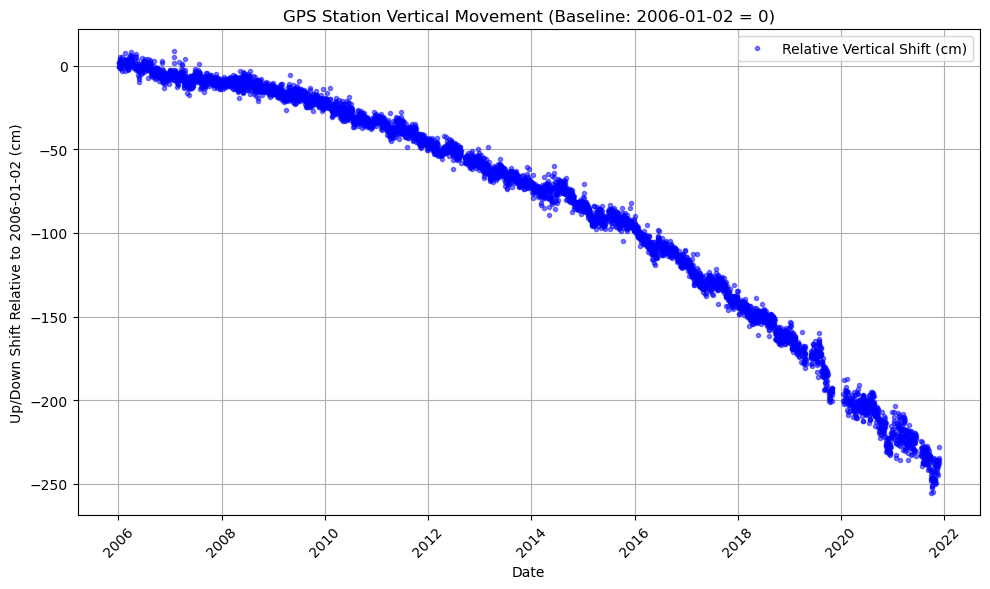

In [1]:
import json
import matplotlib.pyplot as plt
from datetime import datetime

# Read the denormalized JSON file
with open("denormalized_shift_u.json", "r") as f:
    data = json.load(f)

# Get the reference Shift_U from the first day
reference_shift_u = data["station"][0]["Shift_U"]

# Adjust all Shift_U values relative to the first day
relative_data = {
    "success": data["success"],
    "station": [
        {
            "Day": entry["Day"],
            "Shift_U": entry["Shift_U"] - reference_shift_u
        }
        for entry in data["station"]
    ]
}

# Extract dates and adjusted Shift_U values for plotting
dates = []
shift_u_values = []

for entry in relative_data["station"]:
    date = datetime.strptime(entry["Day"], "%Y-%m-%d")
    dates.append(date)
    shift_u_values.append(entry["Shift_U"])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(dates, shift_u_values, marker='o', linestyle='', color='b', alpha=0.5, markersize=3, label='Relative Vertical Shift (cm)')

# Customize the plot
plt.xlabel("Date")
plt.ylabel("Up/Down Shift Relative to 2006-01-02 (cm)")
plt.title("GPS Station Vertical Movement (Baseline: 2006-01-02 = 0)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Optionally, save the adjusted data
with open("relative_denormalized_shift_u.json", "w") as f:
    json.dump(relative_data, f, indent=4)

In [2]:
import json
import pandas as pd

# Read the JSON file
with open("relative_denormalized_shift_u.json", "r") as f:
    data = json.load(f)

# Extract the "station" data (list of dictionaries)
station_data = data["station"]

# Create a Pandas DataFrame
df = pd.DataFrame(station_data)

# Convert "Day" to datetime type for better handling
df["Day"] = pd.to_datetime(df["Day"])

# Display the DataFrame
print(df)

# Optionally, save to CSV if you want
df.to_csv("relative_shift_u.csv", index=False)

            Day     Shift_U
0    2006-01-02    0.000000
1    2006-01-03   -0.868930
2    2006-01-05   -0.898893
3    2006-01-06    2.217269
4    2006-01-07    1.817761
...         ...         ...
5311 2021-11-20 -239.535009
5312 2021-11-21 -227.839412
5313 2021-11-22 -235.799609
5314 2021-11-23 -237.637346
5315 2021-11-24 -234.900716

[5316 rows x 2 columns]


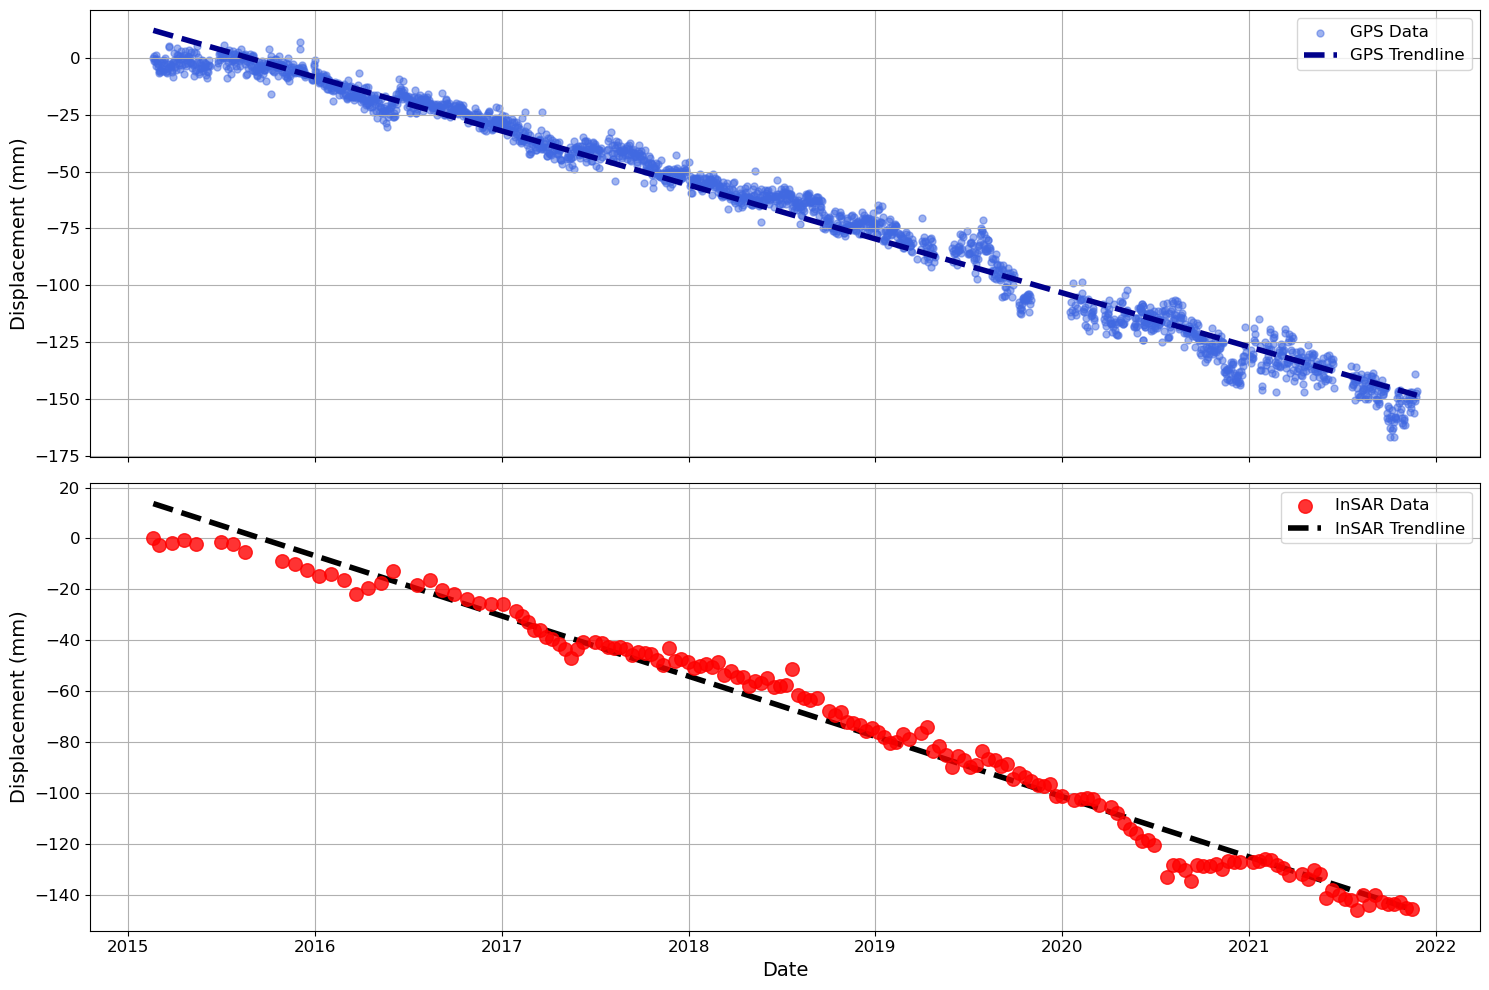

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression

# Step 1: Load GPS data (already in df_gps from previous step)
with open("relative_denormalized_shift_u.json", "r") as f:
    data = json.load(f)
df_gps = pd.DataFrame(data["station"])
df_gps["Day"] = pd.to_datetime(df_gps["Day"])
# Convert Shift_U from cm to mm (1 cm = 10 mm)
#df_gps["Shift_U"] = df_gps["Shift_U"] * 10

# Step 2: Load InSAR data from Excel
# Replace 'insar_data.xlsx' with your actual Excel file name
df_satellite = pd.read_excel("disp.xlsx", sheet_name="Sheet1")
df_satellite["Day"] = pd.to_datetime(df_satellite["Day"], format="%m/%d/%Y")

# Step 3: Find common date range
start_date = max(df_gps["Day"].min(), df_satellite["Day"].min())  # e.g., 2015-02-20
end_date = min(df_gps["Day"].max(), df_satellite["Day"].max())    # e.g., 2015-11-23

# Filter both datasets to the common date range
df_gps_filtered = df_gps[(df_gps["Day"] >= start_date) & (df_gps["Day"] <= end_date)].copy()
df_satellite_filtered = df_satellite[(df_satellite["Day"] >= start_date) & (df_satellite["Day"] <= end_date)].copy()

# Step 4: Adjust displacements to baseline (set start date to 0)
# Get the displacement at the start date
gps_baseline = df_gps_filtered[df_gps_filtered["Day"] == start_date]["Shift_U"].iloc[0]
satellite_baseline = df_satellite_filtered[df_satellite_filtered["Day"] == start_date]["disp"].iloc[0]

# Adjust both datasets
df_gps_filtered["Shift_U"] = df_gps_filtered["Shift_U"] - gps_baseline
df_satellite_filtered["disp"] = df_satellite_filtered["disp"] - satellite_baseline

# Step 5: Add Day_ordinal for trendline calculation (from your code)
df_gps_filtered['Day_ordinal'] = df_gps_filtered['Day'].apply(lambda date: date.toordinal())
df_satellite_filtered['Day_ordinal'] = df_satellite_filtered['Day'].apply(lambda date: date.toordinal())

# Step 6: Plotting (using your code)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot GPS data
ax1.scatter(df_gps_filtered['Day'], df_gps_filtered['Shift_U'], color='royalblue', label='GPS Data', alpha=0.5, s=25)
gps_model = LinearRegression().fit(df_gps_filtered[['Day_ordinal']], df_gps_filtered['Shift_U'])
gps_trendline = gps_model.predict(df_gps_filtered[['Day_ordinal']])
ax1.plot(df_gps_filtered['Day'], gps_trendline, color='darkblue', linestyle='--', linewidth=4, label='GPS Trendline')
ax1.set_ylabel('Displacement (mm)', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=12)
ax1.grid(True)

# Plot InSAR data
ax2.scatter(df_satellite_filtered['Day'], df_satellite_filtered['disp'], color='red', label='InSAR Data', alpha=0.8, s=95, zorder=100)
satellite_model = LinearRegression().fit(df_satellite_filtered[['Day_ordinal']], df_satellite_filtered['disp'])
satellite_trendline = satellite_model.predict(df_satellite_filtered[['Day_ordinal']])
ax2.plot(df_satellite_filtered['Day'], satellite_trendline, color='black', linestyle='--', linewidth=4, label='InSAR Trendline')
ax2.set_ylabel('Displacement (mm)', fontsize=14)
ax2.set_xlabel('Date', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.legend(fontsize=12)
ax2.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [2]:
!pip install openpyxl

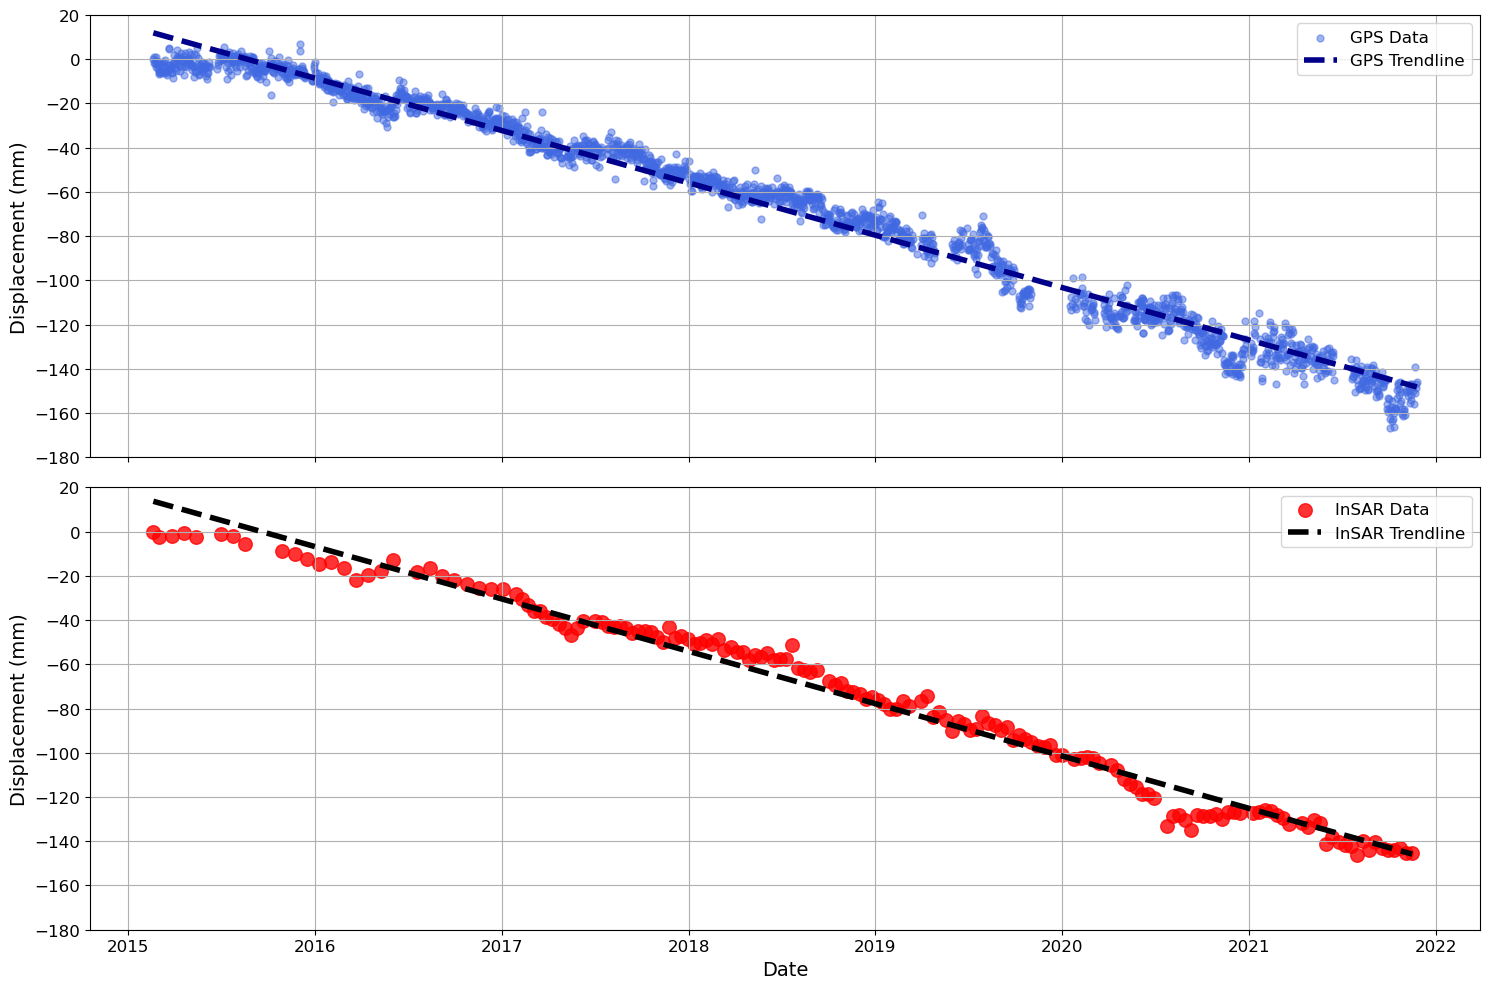

In [9]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
import numpy as np

# Step 1: Load GPS data
with open("relative_denormalized_shift_u.json", "r") as f:
    data = json.load(f)
df_gps = pd.DataFrame(data["station"])
df_gps["Day"] = pd.to_datetime(df_gps["Day"])
# Convert Shift_U from cm to mm (1 cm = 10 mm)
#df_gps["Shift_U"] = df_gps["Shift_U"] * 10

# Step 2: Load InSAR data from Excel
# Replace 'insar_data.xlsx' with your actual Excel file name
df_satellite = pd.read_excel("disp.xlsx", sheet_name="Sheet1")
df_satellite["Day"] = pd.to_datetime(df_satellite["Day"], format="%m/%d/%Y")

# Step 3: Find common date range
start_date = max(df_gps["Day"].min(), df_satellite["Day"].min())  # e.g., 2015-02-20
end_date = min(df_gps["Day"].max(), df_satellite["Day"].max())    # e.g., 2015-11-23

# Filter both datasets to the common date range
df_gps_filtered = df_gps[(df_gps["Day"] >= start_date) & (df_gps["Day"] <= end_date)].copy()
df_satellite_filtered = df_satellite[(df_satellite["Day"] >= start_date) & (df_satellite["Day"] <= end_date)].copy()

# Step 4: Adjust displacements to baseline (set start date to 0)
gps_baseline = df_gps_filtered[df_gps_filtered["Day"] == start_date]["Shift_U"].iloc[0]
satellite_baseline = df_satellite_filtered[df_satellite_filtered["Day"] == start_date]["disp"].iloc[0]

df_gps_filtered["Shift_U"] = df_gps_filtered["Shift_U"] - gps_baseline
df_satellite_filtered["disp"] = df_satellite_filtered["disp"] - satellite_baseline

# Step 5: Add Day_ordinal for trendline calculation
df_gps_filtered['Day_ordinal'] = df_gps_filtered['Day'].apply(lambda date: date.toordinal())
df_satellite_filtered['Day_ordinal'] = df_satellite_filtered['Day'].apply(lambda date: date.toordinal())

# Step 6: Determine y-axis limits (same for both plots, ticks every 20 mm)
# Find the global min and max across both datasets
global_min = min(df_gps_filtered["Shift_U"].min(), df_satellite_filtered["disp"].min())
global_max = max(df_gps_filtered["Shift_U"].max(), df_satellite_filtered["disp"].max())

# Round to nearest 20 mm for tick intervals
y_min = np.floor(global_min / 20) * 20
y_max = np.ceil(global_max / 20) * 20

# Generate tick positions (every 20 mm)
y_ticks = np.arange(y_min, y_max + 20, 20)

# Step 7: Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot GPS data
ax1.scatter(df_gps_filtered['Day'], df_gps_filtered['Shift_U'], color='royalblue', label='GPS Data', alpha=0.5, s=25)
gps_model = LinearRegression().fit(df_gps_filtered[['Day_ordinal']], df_gps_filtered['Shift_U'])
gps_trendline = gps_model.predict(df_gps_filtered[['Day_ordinal']])
ax1.plot(df_gps_filtered['Day'], gps_trendline, color='darkblue', linestyle='--', linewidth=4, label='GPS Trendline')
ax1.set_ylabel('Displacement (mm)', fontsize=14)
ax1.set_ylim(y_min, y_max)  # Set same y-axis limits
ax1.set_yticks(y_ticks)     # Set ticks every 20 mm
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=12)
ax1.grid(True)

# Plot InSAR data
ax2.scatter(df_satellite_filtered['Day'], df_satellite_filtered['disp'], color='red', label='InSAR Data', alpha=0.8, s=95)
satellite_model = LinearRegression().fit(df_satellite_filtered[['Day_ordinal']], df_satellite_filtered['disp'])
satellite_trendline = satellite_model.predict(df_satellite_filtered[['Day_ordinal']])
ax2.plot(df_satellite_filtered['Day'], satellite_trendline, color='black', linestyle='--', linewidth=4, label='InSAR Trendline')
ax2.set_ylabel('Displacement (mm)', fontsize=14)
ax2.set_xlabel('Date', fontsize=14)
ax2.set_ylim(y_min, y_max)  # Set same y-axis limits
ax2.set_yticks(y_ticks)     # Set ticks every 20 mm
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.legend(fontsize=12)
ax2.grid(True)
plt.savefig('comp.png', dpi=300)
# Adjust layout and show plot
plt.tight_layout()
plt.show()

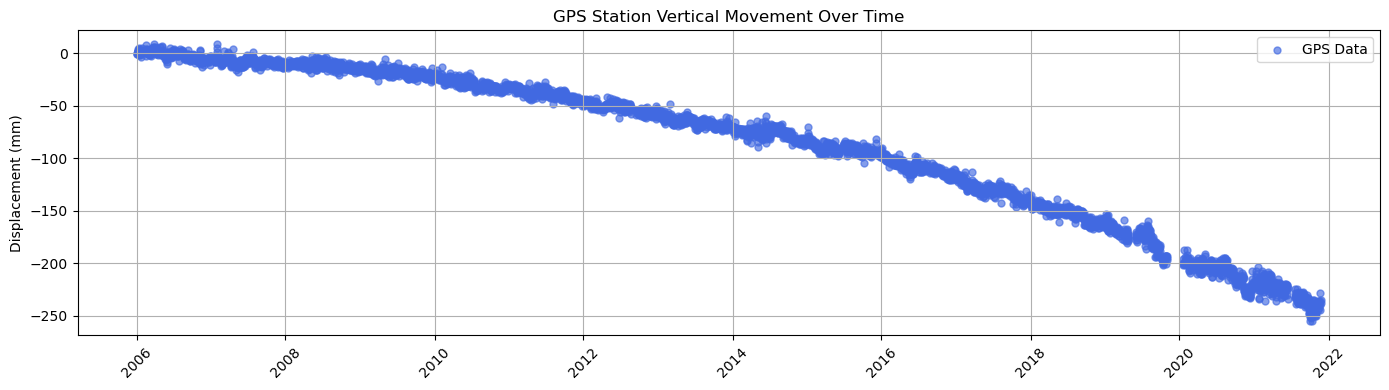

In [24]:
import json
import matplotlib.pyplot as plt
from datetime import datetime

# Read the denormalized JSON file
with open("relative_denormalized_shift_u.json", "r") as f:
    data = json.load(f)

# Extract dates and Shift_U values
dates = []
shift_u_values = []

for entry in data["station"]:
    # Convert "Day" string to datetime object for plotting
    date = datetime.strptime(entry["Day"], "%Y-%m-%d")
    dates.append(date)
    shift_u_values.append(entry["Shift_U"])

# Create the plot
plt.figure(figsize=(14, 4))  # Set figure size

plt.scatter(dates, shift_u_values, color='royalblue', label='GPS Data', alpha=0.65, s=25)

#plt.set_ylabel('Displacement (mm)', fontsize=14)
# Customize the plot
#plt.xlabel("Date")
plt.ylabel("Displacement (mm)")
plt.title("GPS Station Vertical Movement Over Time")
plt.grid(True)
plt.legend()

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig('GPS.png', dpi=300)
# Show the plot
plt.show()

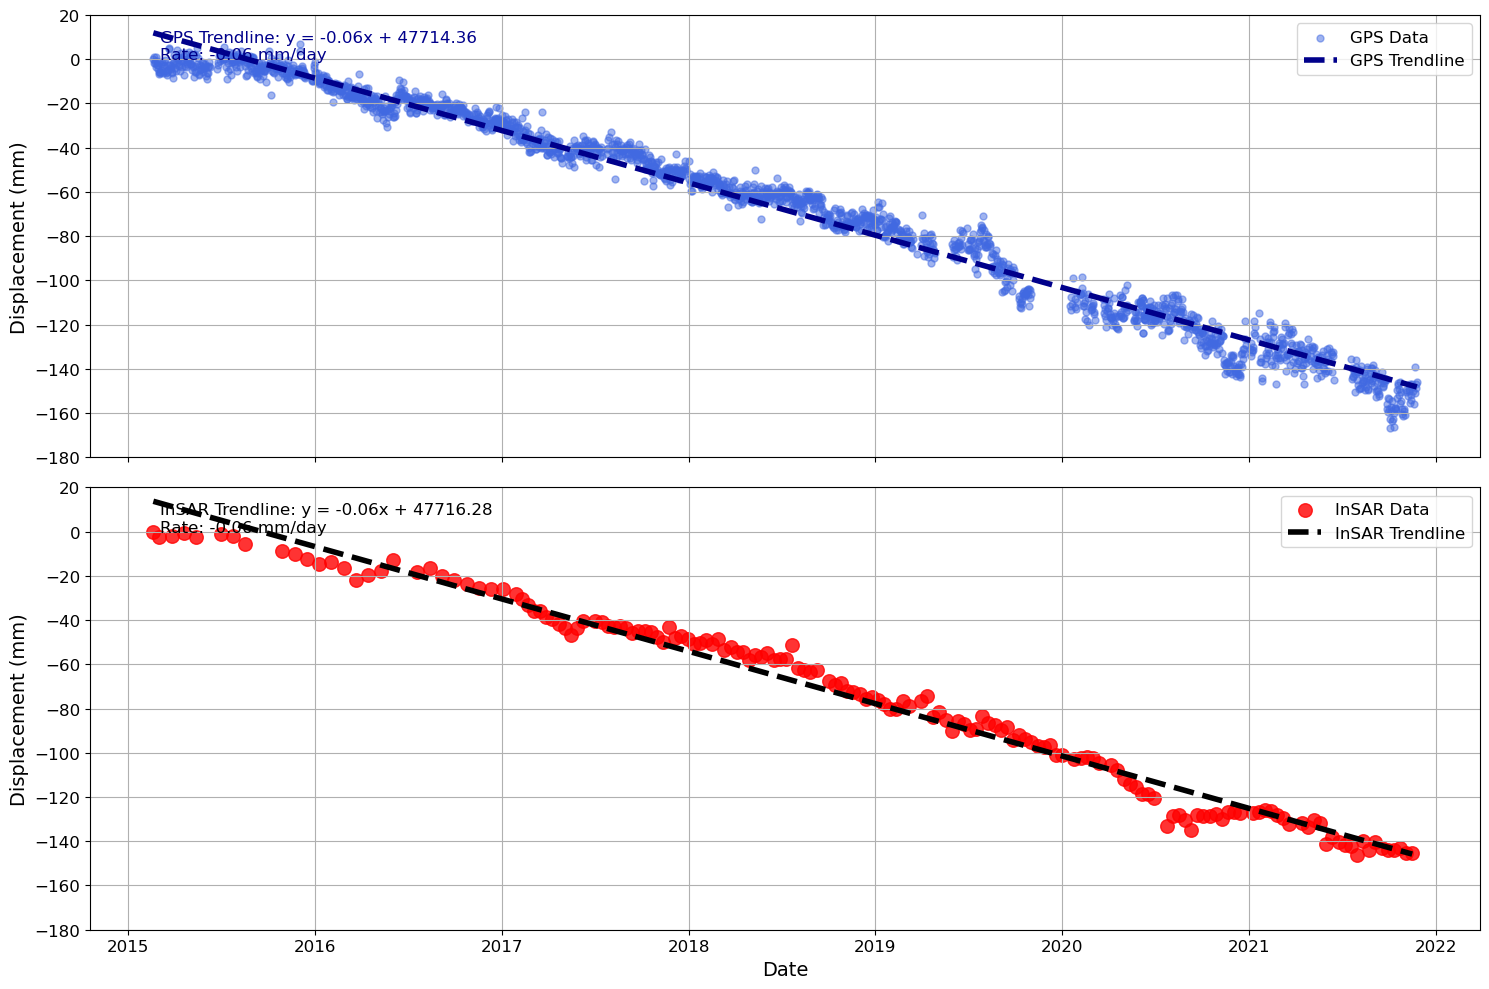

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
import numpy as np

# Step 1: Load GPS data
with open("relative_denormalized_shift_u.json", "r") as f:
    data = json.load(f)
df_gps = pd.DataFrame(data["station"])
df_gps["Day"] = pd.to_datetime(df_gps["Day"])

# Step 2: Load InSAR data from Excel
df_satellite = pd.read_excel("disp.xlsx", sheet_name="Sheet1")
df_satellite["Day"] = pd.to_datetime(df_satellite["Day"], format="%m/%d/%Y")

# Step 3: Find common date range
start_date = max(df_gps["Day"].min(), df_satellite["Day"].min())  
end_date = min(df_gps["Day"].max(), df_satellite["Day"].max())    

df_gps_filtered = df_gps[(df_gps["Day"] >= start_date) & (df_gps["Day"] <= end_date)].copy()
df_satellite_filtered = df_satellite[(df_satellite["Day"] >= start_date) & (df_satellite["Day"] <= end_date)].copy()

# Step 4: Adjust displacements to baseline
gps_baseline = df_gps_filtered[df_gps_filtered["Day"] == start_date]["Shift_U"].iloc[0]
satellite_baseline = df_satellite_filtered[df_satellite_filtered["Day"] == start_date]["disp"].iloc[0]

df_gps_filtered["Shift_U"] = df_gps_filtered["Shift_U"] - gps_baseline
df_satellite_filtered["disp"] = df_satellite_filtered["disp"] - satellite_baseline

# Step 5: Add Day_ordinal for trendline calculation
df_gps_filtered['Day_ordinal'] = df_gps_filtered['Day'].apply(lambda date: date.toordinal())
df_satellite_filtered['Day_ordinal'] = df_satellite_filtered['Day'].apply(lambda date: date.toordinal())

# Step 6: Determine y-axis limits
global_min = min(df_gps_filtered["Shift_U"].min(), df_satellite_filtered["disp"].min())
global_max = max(df_gps_filtered["Shift_U"].max(), df_satellite_filtered["disp"].max())
y_min = np.floor(global_min / 20) * 20
y_max = np.ceil(global_max / 20) * 20
y_ticks = np.arange(y_min, y_max + 20, 20)

# Step 7: Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot GPS data
ax1.scatter(df_gps_filtered['Day'], df_gps_filtered['Shift_U'], color='royalblue', label='GPS Data', alpha=0.5, s=25)
gps_model = LinearRegression().fit(df_gps_filtered[['Day_ordinal']], df_gps_filtered['Shift_U'])
gps_trendline = gps_model.predict(df_gps_filtered[['Day_ordinal']])
ax1.plot(df_gps_filtered['Day'], gps_trendline, color='darkblue', linestyle='--', linewidth=4, label='GPS Trendline')

# Get slope and intercept for GPS trendline
gps_slope = gps_model.coef_[0]
gps_intercept = gps_model.intercept_
ax1.text(0.05, 0.9, f'GPS Trendline: y = {gps_slope:.2f}x + {gps_intercept:.2f}\nRate: {gps_slope:.2f} mm/day', transform=ax1.transAxes, fontsize=12, color='darkblue')

ax1.set_ylabel('Displacement (mm)', fontsize=14)
ax1.set_ylim(y_min, y_max)
ax1.set_yticks(y_ticks)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=12)
ax1.grid(True)

# Plot InSAR data
ax2.scatter(df_satellite_filtered['Day'], df_satellite_filtered['disp'], color='red', label='InSAR Data', alpha=0.8, s=95)
satellite_model = LinearRegression().fit(df_satellite_filtered[['Day_ordinal']], df_satellite_filtered['disp'])
satellite_trendline = satellite_model.predict(df_satellite_filtered[['Day_ordinal']])
ax2.plot(df_satellite_filtered['Day'], satellite_trendline, color='black', linestyle='--', linewidth=4, label='InSAR Trendline')

# Get slope and intercept for InSAR trendline
satellite_slope = satellite_model.coef_[0]
satellite_intercept = satellite_model.intercept_
ax2.text(0.05, 0.9, f'InSAR Trendline: y = {satellite_slope:.2f}x + {satellite_intercept:.2f}\nRate: {satellite_slope:.2f} mm/day', transform=ax2.transAxes, fontsize=12, color='black')

ax2.set_ylabel('Displacement (mm)', fontsize=14)
ax2.set_xlabel('Date', fontsize=14)
ax2.set_ylim(y_min, y_max)
ax2.set_yticks(y_ticks)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.legend(fontsize=12)
ax2.grid(True)

# Save the plot
plt.savefig('comp.png', dpi=300)
plt.tight_layout()
plt.show()


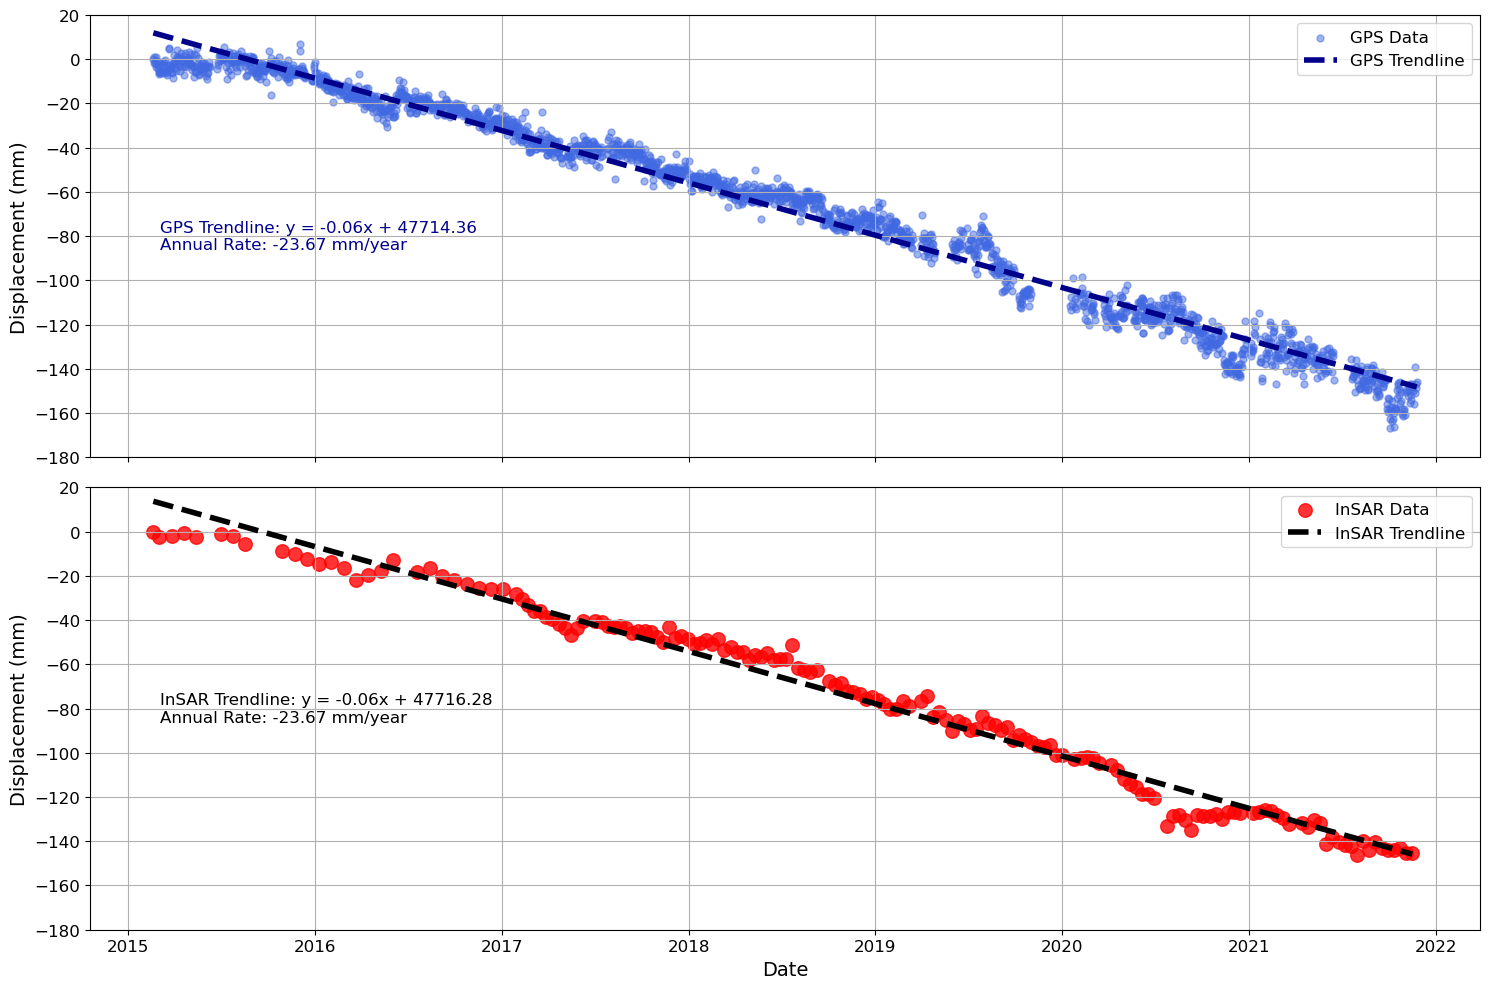

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
import numpy as np

# Step 1: Load GPS data
with open("relative_denormalized_shift_u.json", "r") as f:
    data = json.load(f)
df_gps = pd.DataFrame(data["station"])
df_gps["Day"] = pd.to_datetime(df_gps["Day"])

# Step 2: Load InSAR data from Excel
df_satellite = pd.read_excel("disp.xlsx", sheet_name="Sheet1")
df_satellite["Day"] = pd.to_datetime(df_satellite["Day"], format="%m/%d/%Y")

# Step 3: Find common date range
start_date = max(df_gps["Day"].min(), df_satellite["Day"].min())  
end_date = min(df_gps["Day"].max(), df_satellite["Day"].max())    

df_gps_filtered = df_gps[(df_gps["Day"] >= start_date) & (df_gps["Day"] <= end_date)].copy()
df_satellite_filtered = df_satellite[(df_satellite["Day"] >= start_date) & (df_satellite["Day"] <= end_date)].copy()

# Step 4: Adjust displacements to baseline
gps_baseline = df_gps_filtered[df_gps_filtered["Day"] == start_date]["Shift_U"].iloc[0]
satellite_baseline = df_satellite_filtered[df_satellite_filtered["Day"] == start_date]["disp"].iloc[0]

df_gps_filtered["Shift_U"] = df_gps_filtered["Shift_U"] - gps_baseline
df_satellite_filtered["disp"] = df_satellite_filtered["disp"] - satellite_baseline

# Step 5: Add Day_ordinal for trendline calculation
df_gps_filtered['Day_ordinal'] = df_gps_filtered['Day'].apply(lambda date: date.toordinal())
df_satellite_filtered['Day_ordinal'] = df_satellite_filtered['Day'].apply(lambda date: date.toordinal())

# Step 6: Determine y-axis limits
global_min = min(df_gps_filtered["Shift_U"].min(), df_satellite_filtered["disp"].min())
global_max = max(df_gps_filtered["Shift_U"].max(), df_satellite_filtered["disp"].max())
y_min = np.floor(global_min / 20) * 20
y_max = np.ceil(global_max / 20) * 20
y_ticks = np.arange(y_min, y_max + 20, 20)

# Step 7: Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot GPS data
ax1.scatter(df_gps_filtered['Day'], df_gps_filtered['Shift_U'], color='royalblue', label='GPS Data', alpha=0.5, s=25)
gps_model = LinearRegression().fit(df_gps_filtered[['Day_ordinal']], df_gps_filtered['Shift_U'])
gps_trendline = gps_model.predict(df_gps_filtered[['Day_ordinal']])
ax1.plot(df_gps_filtered['Day'], gps_trendline, color='darkblue', linestyle='--', linewidth=4, label='GPS Trendline')

# Get slope and intercept for GPS trendline
gps_slope = gps_model.coef_[0]
gps_intercept = gps_model.intercept_

# Convert daily rate to annual rate (365 days in a year)
gps_annual_rate = gps_slope * 365

# Display formula and annual rate in the left-center
ax1.text(0.05, 0.5, f'GPS Trendline: y = {gps_slope:.2f}x + {gps_intercept:.2f}\nAnnual Rate: {gps_annual_rate:.2f} mm/year',
         transform=ax1.transAxes, fontsize=12, color='darkblue', verticalalignment='center')

ax1.set_ylabel('Displacement (mm)', fontsize=14)
ax1.set_ylim(y_min, y_max)
ax1.set_yticks(y_ticks)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=12)
ax1.grid(True)

# Plot InSAR data
ax2.scatter(df_satellite_filtered['Day'], df_satellite_filtered['disp'], color='red', label='InSAR Data', alpha=0.8, s=95)
satellite_model = LinearRegression().fit(df_satellite_filtered[['Day_ordinal']], df_satellite_filtered['disp'])
satellite_trendline = satellite_model.predict(df_satellite_filtered[['Day_ordinal']])
ax2.plot(df_satellite_filtered['Day'], satellite_trendline, color='black', linestyle='--', linewidth=4, label='InSAR Trendline')

# Get slope and intercept for InSAR trendline
satellite_slope = satellite_model.coef_[0]
satellite_intercept = satellite_model.intercept_

# Convert daily rate to annual rate (365 days in a year)
satellite_annual_rate = satellite_slope * 365

# Display formula and annual rate in the left-center
ax2.text(0.05, 0.5, f'InSAR Trendline: y = {satellite_slope:.2f}x + {satellite_intercept:.2f}\nAnnual Rate: {satellite_annual_rate:.2f} mm/year',
         transform=ax2.transAxes, fontsize=12, color='black', verticalalignment='center')

ax2.set_ylabel('Displacement (mm)', fontsize=14)
ax2.set_xlabel('Date', fontsize=14)
ax2.set_ylim(y_min, y_max)
ax2.set_yticks(y_ticks)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.legend(fontsize=12)
ax2.grid(True)

# Save the plot
plt.savefig('comp.png', dpi=300)
plt.tight_layout()
plt.show()


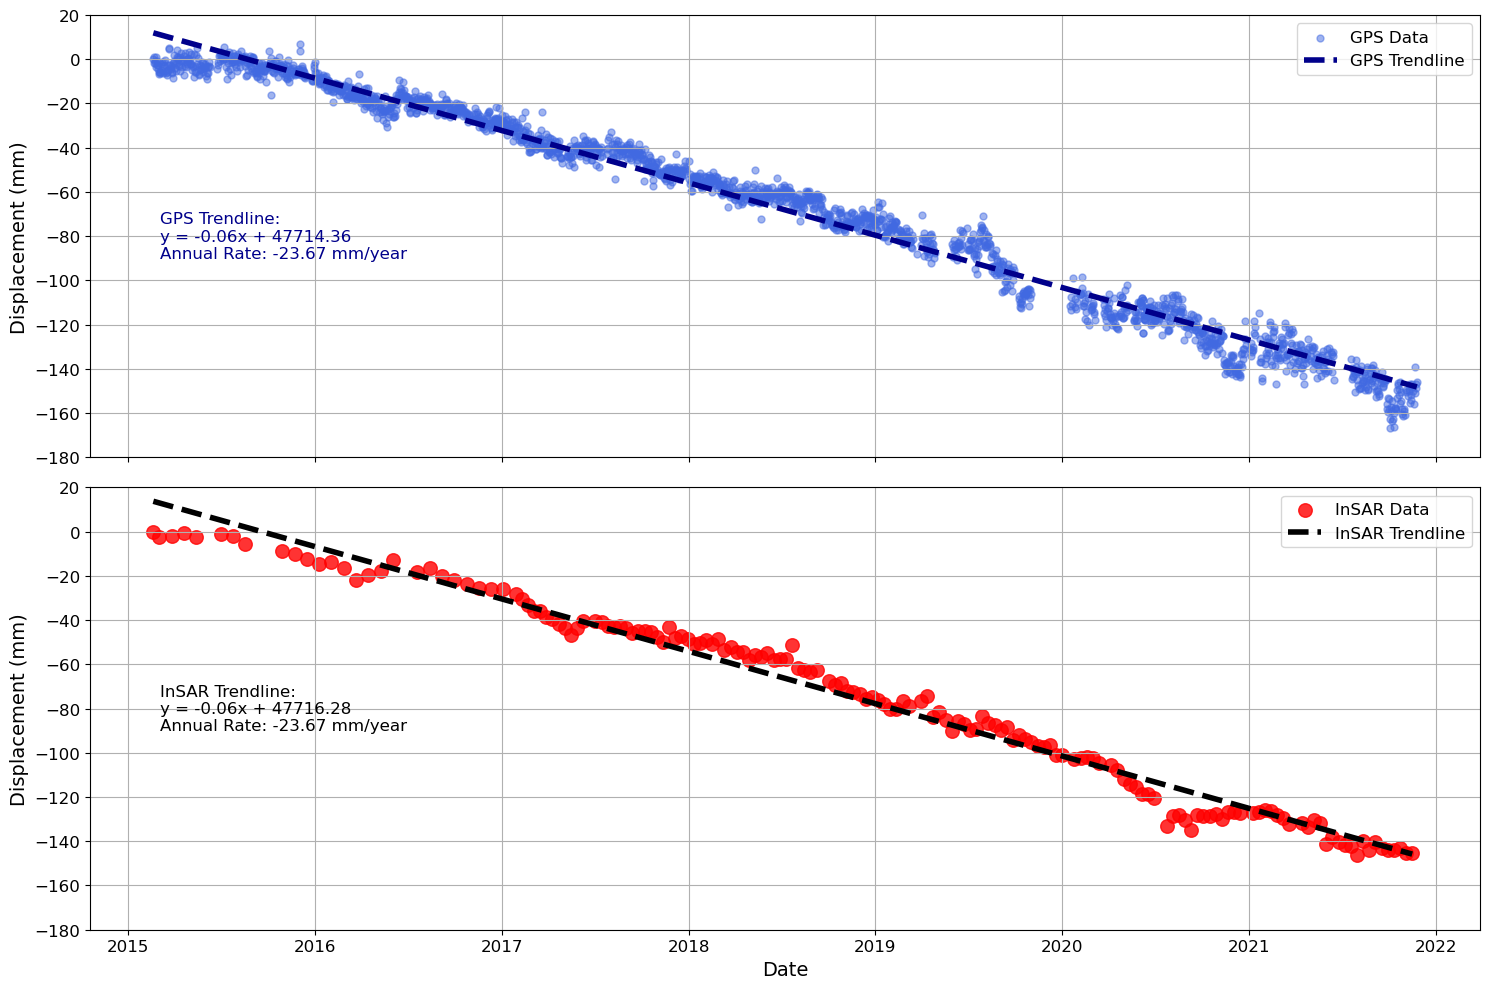

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
import numpy as np

# Step 1: Load GPS data
with open("relative_denormalized_shift_u.json", "r") as f:
    data = json.load(f)
df_gps = pd.DataFrame(data["station"])
df_gps["Day"] = pd.to_datetime(df_gps["Day"])

# Step 2: Load InSAR data from Excel
df_satellite = pd.read_excel("disp.xlsx", sheet_name="Sheet1")
df_satellite["Day"] = pd.to_datetime(df_satellite["Day"], format="%m/%d/%Y")

# Step 3: Find common date range
start_date = max(df_gps["Day"].min(), df_satellite["Day"].min())  
end_date = min(df_gps["Day"].max(), df_satellite["Day"].max())    

df_gps_filtered = df_gps[(df_gps["Day"] >= start_date) & (df_gps["Day"] <= end_date)].copy()
df_satellite_filtered = df_satellite[(df_satellite["Day"] >= start_date) & (df_satellite["Day"] <= end_date)].copy()

# Step 4: Adjust displacements to baseline
gps_baseline = df_gps_filtered[df_gps_filtered["Day"] == start_date]["Shift_U"].iloc[0]
satellite_baseline = df_satellite_filtered[df_satellite_filtered["Day"] == start_date]["disp"].iloc[0]

df_gps_filtered["Shift_U"] = df_gps_filtered["Shift_U"] - gps_baseline
df_satellite_filtered["disp"] = df_satellite_filtered["disp"] - satellite_baseline

# Step 5: Add Day_ordinal for trendline calculation
df_gps_filtered['Day_ordinal'] = df_gps_filtered['Day'].apply(lambda date: date.toordinal())
df_satellite_filtered['Day_ordinal'] = df_satellite_filtered['Day'].apply(lambda date: date.toordinal())

# Step 6: Determine y-axis limits
global_min = min(df_gps_filtered["Shift_U"].min(), df_satellite_filtered["disp"].min())
global_max = max(df_gps_filtered["Shift_U"].max(), df_satellite_filtered["disp"].max())
y_min = np.floor(global_min / 20) * 20
y_max = np.ceil(global_max / 20) * 20
y_ticks = np.arange(y_min, y_max + 20, 20)

# Step 7: Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# === GPS Trendline ===
ax1.scatter(df_gps_filtered['Day'], df_gps_filtered['Shift_U'], color='royalblue', label='GPS Data', alpha=0.5, s=25)
gps_model = LinearRegression().fit(df_gps_filtered[['Day_ordinal']], df_gps_filtered['Shift_U'])
gps_slope = gps_model.coef_[0]
gps_intercept = gps_model.intercept_
gps_trendline = gps_model.predict(df_gps_filtered[['Day_ordinal']])
gps_annual_rate = gps_slope * 365  # mm/year

ax1.plot(df_gps_filtered['Day'], gps_trendline, color='darkblue', linestyle='--', linewidth=4, label='GPS Trendline')
ax1.text(0.05, 0.5,
         f'GPS Trendline:\ny = {gps_slope:.2f}x + {gps_intercept:.2f}\nAnnual Rate: {gps_annual_rate:.2f} mm/year',
         transform=ax1.transAxes, fontsize=12, color='darkblue', verticalalignment='center')

ax1.set_ylabel('Displacement (mm)', fontsize=14)
ax1.set_ylim(y_min, y_max)
ax1.set_yticks(y_ticks)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=12)
ax1.grid(True)

# === InSAR Trendline ===
ax2.scatter(df_satellite_filtered['Day'], df_satellite_filtered['disp'], color='red', label='InSAR Data', alpha=0.8, s=95)
satellite_model = LinearRegression().fit(df_satellite_filtered[['Day_ordinal']], df_satellite_filtered['disp'])
satellite_slope = satellite_model.coef_[0]
satellite_intercept = satellite_model.intercept_
satellite_trendline = satellite_model.predict(df_satellite_filtered[['Day_ordinal']])
satellite_annual_rate = satellite_slope * 365  # mm/year

ax2.plot(df_satellite_filtered['Day'], satellite_trendline, color='black', linestyle='--', linewidth=4, label='InSAR Trendline')
ax2.text(0.05, 0.5,
         f'InSAR Trendline:\ny = {satellite_slope:.2f}x + {satellite_intercept:.2f}\nAnnual Rate: {satellite_annual_rate:.2f} mm/year',
         transform=ax2.transAxes, fontsize=12, color='black', verticalalignment='center')

ax2.set_ylabel('Displacement (mm)', fontsize=14)
ax2.set_xlabel('Date', fontsize=14)
ax2.set_ylim(y_min, y_max)
ax2.set_yticks(y_ticks)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.legend(fontsize=12)
ax2.grid(True)

# Save and show the plot
plt.tight_layout()
plt.savefig('comp.png', dpi=300)
plt.show()


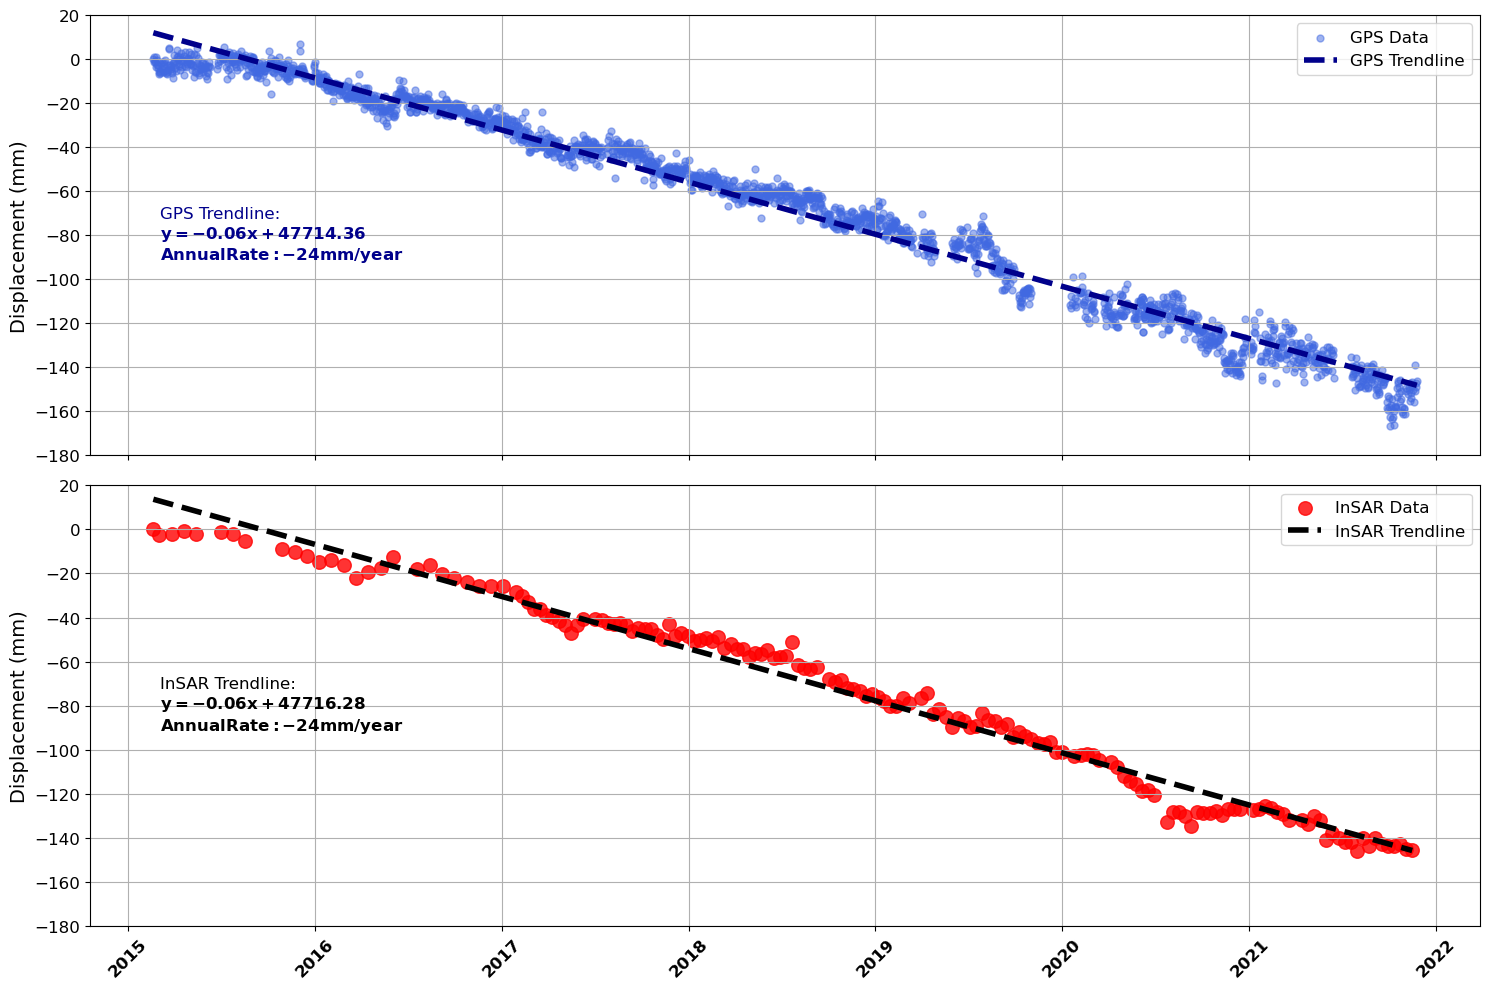

In [5]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
import numpy as np

# Step 1: Load GPS data
with open("relative_denormalized_shift_u.json", "r") as f:
    data = json.load(f)
df_gps = pd.DataFrame(data["station"])
df_gps["Day"] = pd.to_datetime(df_gps["Day"])

# Step 2: Load InSAR data from Excel
df_satellite = pd.read_excel("disp.xlsx", sheet_name="Sheet1")
df_satellite["Day"] = pd.to_datetime(df_satellite["Day"], format="%m/%d/%Y")

# Step 3: Find common date range
start_date = max(df_gps["Day"].min(), df_satellite["Day"].min())  
end_date = min(df_gps["Day"].max(), df_satellite["Day"].max())    

df_gps_filtered = df_gps[(df_gps["Day"] >= start_date) & (df_gps["Day"] <= end_date)].copy()
df_satellite_filtered = df_satellite[(df_satellite["Day"] >= start_date) & (df_satellite["Day"] <= end_date)].copy()

# Step 4: Adjust displacements to baseline
gps_baseline = df_gps_filtered[df_gps_filtered["Day"] == start_date]["Shift_U"].iloc[0]
satellite_baseline = df_satellite_filtered[df_satellite_filtered["Day"] == start_date]["disp"].iloc[0]

df_gps_filtered["Shift_U"] = df_gps_filtered["Shift_U"] - gps_baseline
df_satellite_filtered["disp"] = df_satellite_filtered["disp"] - satellite_baseline

# Step 5: Add Day_ordinal for trendline calculation
df_gps_filtered['Day_ordinal'] = df_gps_filtered['Day'].apply(lambda date: date.toordinal())
df_satellite_filtered['Day_ordinal'] = df_satellite_filtered['Day'].apply(lambda date: date.toordinal())

# Step 6: Determine y-axis limits
global_min = min(df_gps_filtered["Shift_U"].min(), df_satellite_filtered["disp"].min())
global_max = max(df_gps_filtered["Shift_U"].max(), df_satellite_filtered["disp"].max())
y_min = np.floor(global_min / 20) * 20
y_max = np.ceil(global_max / 20) * 20
y_ticks = np.arange(y_min, y_max + 20, 20)

# Step 7: Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# === GPS Trendline ===
ax1.scatter(df_gps_filtered['Day'], df_gps_filtered['Shift_U'], color='royalblue', label='GPS Data', alpha=0.5, s=25)
gps_model = LinearRegression().fit(df_gps_filtered[['Day_ordinal']], df_gps_filtered['Shift_U'])
gps_slope = gps_model.coef_[0]
gps_intercept = gps_model.intercept_
gps_trendline = gps_model.predict(df_gps_filtered[['Day_ordinal']])
gps_annual_rate = int(round(gps_slope * 365))  # mm/year

ax1.plot(df_gps_filtered['Day'], gps_trendline, color='darkblue', linestyle='--', linewidth=4, label='GPS Trendline')
ax1.text(0.05, 0.5,
         f'GPS Trendline:\n$\\bf{{y = {gps_slope:.2f}x + {gps_intercept:.2f}}}$\n$\\bf{{Annual Rate: {gps_annual_rate} mm/year}}$',
         transform=ax1.transAxes, fontsize=12, color='darkblue', verticalalignment='center')

ax1.set_ylabel('Displacement (mm)', fontsize=14)
ax1.set_ylim(y_min, y_max)
ax1.set_yticks(y_ticks)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(fontsize=12)
ax1.grid(True)

# === InSAR Trendline ===
ax2.scatter(df_satellite_filtered['Day'], df_satellite_filtered['disp'], color='red', label='InSAR Data', alpha=0.8, s=95)
satellite_model = LinearRegression().fit(df_satellite_filtered[['Day_ordinal']], df_satellite_filtered['disp'])
satellite_slope = satellite_model.coef_[0]
satellite_intercept = satellite_model.intercept_
satellite_trendline = satellite_model.predict(df_satellite_filtered[['Day_ordinal']])
satellite_annual_rate = int(round(satellite_slope * 365))  # mm/year

ax2.plot(df_satellite_filtered['Day'], satellite_trendline, color='black', linestyle='--', linewidth=4, label='InSAR Trendline')
ax2.text(0.05, 0.5,
         f'InSAR Trendline:\n$\\bf{{y = {satellite_slope:.2f}x + {satellite_intercept:.2f}}}$\n$\\bf{{Annual Rate: {satellite_annual_rate} mm/year}}$',
         transform=ax2.transAxes, fontsize=12, color='black', verticalalignment='center')

ax2.set_ylabel('Displacement (mm)', fontsize=14)
#ax2.set_xlabel('Date', fontsize=14, fontweight='bold')
ax2.set_ylim(y_min, y_max)
ax2.set_yticks(y_ticks)
ax2.tick_params(axis='y', which='major', labelsize=12)
ax2.tick_params(axis='x', which='major', labelsize=12, labelrotation=45, labelcolor='black')

# Bold x-axis tick labels
for label in ax2.get_xticklabels():
    label.set_fontweight('bold')

ax2.legend(fontsize=12)
ax2.grid(True)

# Save and show the plot
plt.tight_layout()
plt.savefig('comp.png', dpi=300)
plt.show()


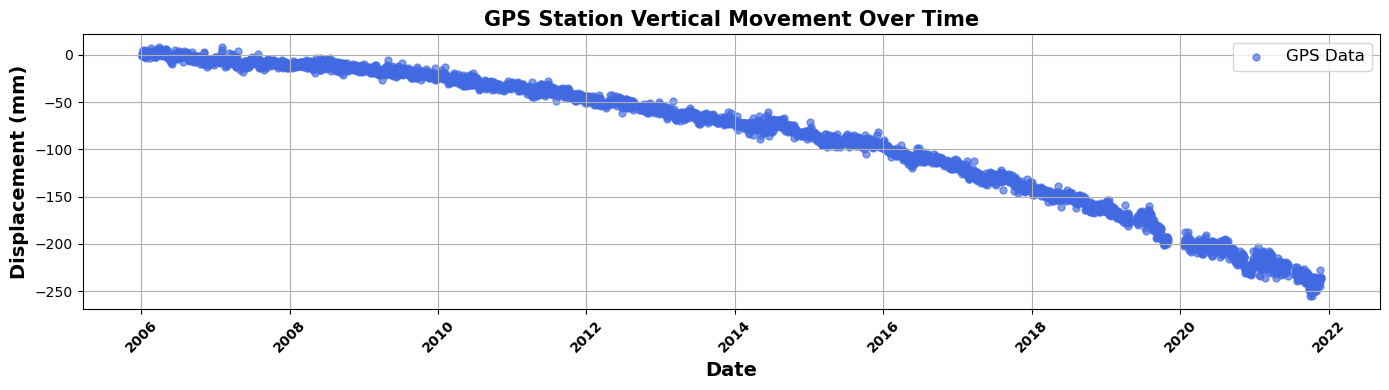

In [6]:
import json
import matplotlib.pyplot as plt
from datetime import datetime

# Read the denormalized JSON file
with open("relative_denormalized_shift_u.json", "r") as f:
    data = json.load(f)

# Extract dates and Shift_U values
dates = []
shift_u_values = []

for entry in data["station"]:
    # Convert "Day" string to datetime object for plotting
    date = datetime.strptime(entry["Day"], "%Y-%m-%d")
    dates.append(date)
    shift_u_values.append(entry["Shift_U"])

# Create the plot
plt.figure(figsize=(14, 4))  # Set figure size

plt.scatter(dates, shift_u_values, color='royalblue', label='GPS Data', alpha=0.65, s=25)

# Customize the plot
plt.xlabel("Date", fontsize=14, fontweight='bold')
plt.ylabel("Displacement (mm)", fontsize=14, fontweight='bold')
plt.title("GPS Station Vertical Movement Over Time", fontsize=15, fontweight='bold')
plt.grid(True)
plt.legend(fontsize=12)

# Rotate x-axis labels and make them bold
plt.xticks(rotation=45)
for label in plt.gca().get_xticklabels():
    label.set_fontweight('bold')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig('GPS.png', dpi=300)
plt.show()


<>:38: SyntaxWarning: invalid escape sequence '\ '
<>:38: SyntaxWarning: invalid escape sequence '\ '
C:\Users\acer\AppData\Local\Temp\ipykernel_5980\2400635099.py:38: SyntaxWarning: invalid escape sequence '\ '
  f"$\\bf{{Trendline:}}$\ny = {slope:.2f}x + {intercept:.2f}\n$\\bf{{Annual\ Rate:}}$ {annual_rate} mm/year",


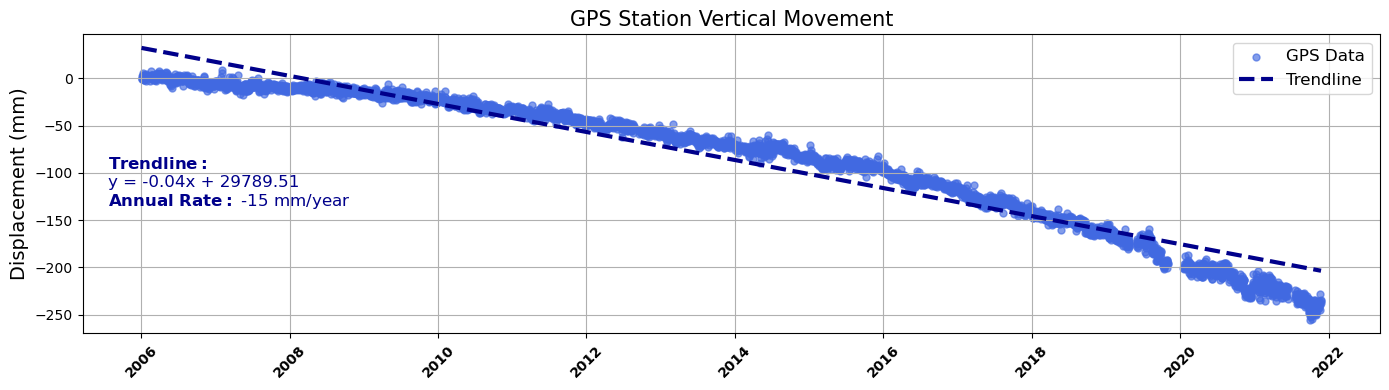

In [12]:
import json
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
import numpy as np

# Read the denormalized JSON file
with open("relative_denormalized_shift_u.json", "r") as f:
    data = json.load(f)

# Extract dates and Shift_U values
dates = []
shift_u_values = []

for entry in data["station"]:
    date = datetime.strptime(entry["Day"], "%Y-%m-%d")
    dates.append(date)
    shift_u_values.append(entry["Shift_U"])

# Prepare data for trendline
date_ordinal = [d.toordinal() for d in dates]
X = np.array(date_ordinal).reshape(-1, 1)
y = np.array(shift_u_values)

model = LinearRegression().fit(X, y)
slope = model.coef_[0]
intercept = model.intercept_
trendline = model.predict(X)
annual_rate = int(round(slope * 365))  # mm/year, without decimals

# Create the plot
plt.figure(figsize=(14, 4))
plt.scatter(dates, shift_u_values, color='royalblue', label='GPS Data', alpha=0.65, s=25)
plt.plot(dates, trendline, color='darkblue', linestyle='--', linewidth=3, label='Trendline')

# Add trendline equation and annual rate
plt.text(0.02, 0.5,
         f"$\\bf{{Trendline:}}$\ny = {slope:.2f}x + {intercept:.2f}\n$\\bf{{Annual\ Rate:}}$ {annual_rate} mm/year",
         transform=plt.gca().transAxes, fontsize=12, color='darkblue', verticalalignment='center')

# Labels and formatting
#plt.xlabel("Date", fontsize=14, fontweight='bold')
plt.ylabel("Displacement (mm)", fontsize=14) #, fontweight='bold
plt.title("GPS Station Vertical Movement", fontsize=15) #fontweight='bold'
plt.grid(True)
plt.legend(fontsize=12)

# Rotate and bold x-axis tick labels
plt.xticks(rotation=45)
for label in plt.gca().get_xticklabels():
    label.set_fontweight('bold')

# Save and show
plt.tight_layout()
plt.savefig('GPS.png', dpi=300)
plt.show()
